<a href="https://colab.research.google.com/github/MarsIana1804/Google_Colab_Notebook/blob/main/My_Copy_of_OverfittingHomeWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:



df = pd.read_csv('/content/drive/My Drive/bikes_rent.csv', encoding='utf-8') # put your code here
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', 5)
display(df)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,10.505372,1796
730,1,1,12,0,1,1,2,8.849153,11.17435,57.7500,10.374682,4.637766,2729


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

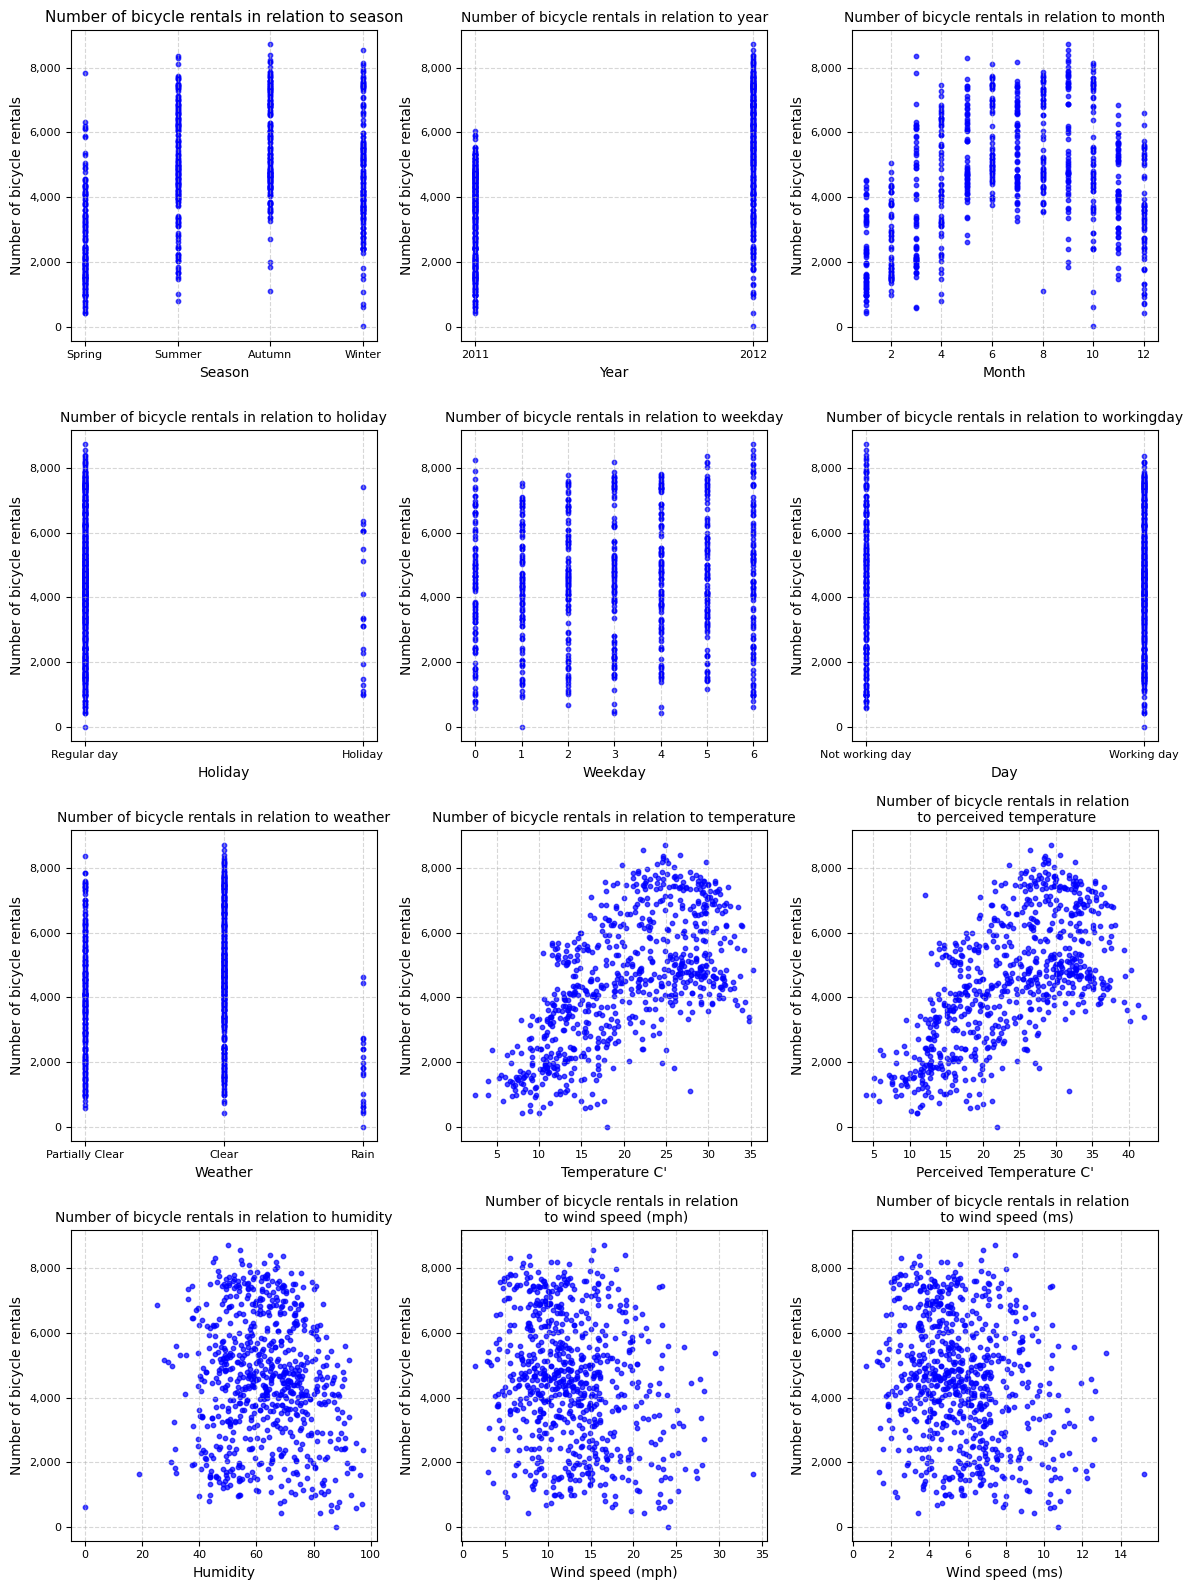

In [ ]:


from matplotlib.ticker import FuncFormatter

# Put you code here
df['season_label'] = df['season'].map({1: 'Spring', 2: 'Summer', 3: 'Autumn', 4: 'Winter'})
df['year_label'] = df['yr'].map({0: '2011', 1: '2012'})
df['holiday_label'] = df['holiday'].map({0: 'Regular day', 1: 'Holiday'})
df['working_day_label'] = df['workingday'].map({0: 'Not working day', 1: 'Working day'})
df['weathersit_label'] = df['weathersit'].map({1: 'Clear', 2: 'Partially Clear', 3: 'Rain', 4: 'Rain / Fog'})
df['temp_int'] = df['temp'].astype(int)
df['atemp_int'] = df['atemp'].astype(int)
df['humidity_int'] = df['hum'].astype(int)
df['wind_speed_mph_rnd'] = df['windspeed(mph)'].round()
df['wind_speed_ms_rnd'] = df['windspeed(ms)'].round()

def format_large_numbers(x, pos):
    return f'{int(x):,}'

fig, axes = plt.subplots(4, 3, figsize=(12, 16)) # 1 row, 2 columns
#seasonly_sum = df.groupby('season_label')['cnt'].sum()
#print(seasonly_sum)
axes[0][0].scatter(df['season_label'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[0][0].set_title("Number of bicycle rentals in relation to season", fontsize=11)
axes[0][0].set_xlabel("Season", fontsize=10)
axes[0][0].tick_params(axis='x', labelsize=8)
axes[0][0].set_ylabel("Number of bicycle rentals", fontsize=10)
axes[0][0].tick_params(axis='y', labelsize=8)
axes[0][0].grid(True, linestyle='--', alpha=0.5)
axes[0][0].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))


yearly_sum = df.groupby('year_label')['cnt'].sum()
#print(yearly_sum)
#axes[0][1].bar(yearly_sum.index, yearly_sum.values, edgecolor='blue', width=0.5 )# linestyle='-', color='orange')
axes[0][1].scatter(df['year_label'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[0][1].set_title("Number of bicycle rentals in relation to year", fontsize=10)
axes[0][1].set_xlabel("Year", fontsize=10)
axes[0][1].tick_params(axis='x', labelsize=8)
axes[0][1].set_ylabel("Number of bicycle rentals", fontsize=10)
axes[0][1].tick_params(axis='y', labelsize=8)
axes[0][1].grid(True, linestyle='--', alpha=0.5)
axes[0][1].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))


monthly_sum = df.groupby('mnth')['cnt'].sum()
#print(yearly_sum)
#axes[0][2].plot(monthly_sum.index, monthly_sum.values, color='pink')
axes[0][2].scatter(df['mnth'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[0][2].set_title("Number of bicycle rentals in relation to month", fontsize=10)
axes[0][2].set_xlabel("Month", fontsize=10)
axes[0][2].tick_params(axis='x', labelsize=8)
axes[0][2].set_ylabel("Number of bicycle rentals", fontsize=10)
axes[0][2].tick_params(axis='y', labelsize=8)
axes[0][2].grid(True, linestyle='--', alpha=0.5)
axes[0][2].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))





#holiday_day_sum = df.groupby('holiday_label')['cnt'].sum()
#print(week_day_sum)
#axes[1][0].bar(holiday_day_sum.index, holiday_day_sum.values, color='brown', width=0.5)
axes[1][0].scatter(df['holiday_label'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[1][0].set_title("Number of bicycle rentals in relation to holiday", fontsize=10)
axes[1][0].set_xlabel("Holiday", fontsize=10)
axes[1][0].tick_params(axis='x', labelsize=8)
axes[1][0].set_ylabel("Number of bicycle rentals", fontsize=10)
axes[1][0].tick_params(axis='y', labelsize=8)
axes[1][0].grid(True, linestyle='--', alpha=0.5)
axes[1][0].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))

# 0 - is it Sunday?
#week_day_sum = df.groupby('weekday')['cnt'].sum()
#print(week_day_sum)
#axes[1][1].plot(week_day_sum.index, week_day_sum.values, color='red')
axes[1][1].scatter(df['weekday'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[1][1].set_title("Number of bicycle rentals in relation to weekday", fontsize=10)
axes[1][1].set_xlabel("Weekday", fontsize=10)
axes[1][1].tick_params(axis='x', labelsize=8)
axes[1][1].set_ylabel("Number of bicycle rentals", fontsize=10)
axes[1][1].tick_params(axis='y', labelsize=8)
axes[1][1].grid(True, linestyle='--', alpha=0.5)
axes[1][1].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))

#workingday_sum = df.groupby('working_day_label')['cnt'].sum()
#print(workingday_sum)
#axes[1][2].bar(workingday_sum.index, workingday_sum.values, color='green', edgecolor='green', width=0.5 )# linestyle='-', color='orange')
axes[1][2].scatter(df['working_day_label'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[1][2].set_title("Number of bicycle rentals in relation to workingday", fontsize=10)
axes[1][2].set_xlabel("Day", fontsize=10)
axes[1][2].tick_params(axis='x', labelsize=8)
axes[1][2].set_ylabel("Number of bicycle rentals", fontsize=10)
axes[1][2].tick_params(axis='y', labelsize=8)
axes[1][2].grid(True, linestyle='--', alpha=0.5)
axes[1][2].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))






#weather_sum = df.groupby('weathersit_label')['cnt'].sum()
#print(weather_sum)
#axes[2][0].plot(weather_sum.index, weather_sum.values, color='purple')
axes[2][0].scatter(df['weathersit_label'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[2][0].set_title("Number of bicycle rentals in relation to weather", fontsize=10)
axes[2][0].set_xlabel("Weather", fontsize=10)
axes[2][0].tick_params(axis='x', labelsize=8)
axes[2][0].set_ylabel("Number of bicycle rentals", fontsize=10)
axes[2][0].tick_params(axis='y', labelsize=8)
axes[2][0].grid(True, linestyle='--', alpha=0.5)
axes[2][0].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))


#temperature_sum = df.groupby('temp_int')['cnt'].sum()
#print(week_day_sum)
#axes[2][1].plot(temperature_sum.index, temperature_sum.values, color='blue')
axes[2][1].scatter(df['temp'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[2][1].set_title("Number of bicycle rentals in relation to temperature", fontsize=10)
axes[2][1].set_xlabel("Temperature C'", fontsize=10)
axes[2][1].tick_params(axis='x', labelsize=8)
axes[2][1].set_ylabel("Number of bicycle rentals", fontsize=10)
axes[2][1].tick_params(axis='y', labelsize=8)
axes[2][1].grid(True, linestyle='--', alpha=0.5)
axes[2][1].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))




#perceived_temperature_sum = df.groupby('atemp_int')['cnt'].sum()
#print(week_day_sum)
#axes[2][2].plot(perceived_temperature_sum.index, perceived_temperature_sum.values, color='red')
axes[2][2].scatter(df['atemp'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[2][2].set_title(f"Number of bicycle rentals in relation \n to perceived temperature", fontsize=10)
axes[2][2].set_xlabel("Perceived Temperature C'", fontsize=10)
axes[2][2].tick_params(axis='x', labelsize=8)
axes[2][2].set_ylabel("Number of bicycle rentals", fontsize=10)
axes[2][2].tick_params(axis='y', labelsize=8)
axes[2][2].grid(True, linestyle='--', alpha=0.5)
axes[2][2].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))






#humidity_sum = df.groupby('humidity_int')['cnt'].sum()
#print(week_day_sum)
#axes[3][0].plot(humidity_sum.index, humidity_sum.values, color='magenta')
axes[3][0].scatter(df['hum'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[3][0].set_title(f"Number of bicycle rentals in relation to humidity", fontsize=10)
axes[3][0].set_xlabel("Humidity", fontsize=10)
axes[3][0].tick_params(axis='x', labelsize=8)
axes[3][0].set_ylabel("Number of bicycle rentals", fontsize=10)
axes[3][0].tick_params(axis='y', labelsize=8)
axes[3][0].grid(True, linestyle='--', alpha=0.5)
axes[3][0].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))


#windspeed_mph_sum = df.groupby('wind_speed_mph_rnd')['cnt'].sum()
#print(week_day_sum)
#axes[3][1].plot(windspeed_mph_sum.index, windspeed_mph_sum.values, color='orange')
axes[3][1].scatter(df['windspeed(mph)'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[3][1].set_title(f"Number of bicycle rentals in relation \n to wind speed (mph)", fontsize=10)
axes[3][1].set_xlabel("Wind speed (mph)", fontsize=10)
axes[3][1].tick_params(axis='x', labelsize=8)
axes[3][1].set_ylabel("Number of bicycle rentals", fontsize=10)
axes[3][1].tick_params(axis='y', labelsize=8)
axes[3][1].grid(True, linestyle='--', alpha=0.5)
axes[3][1].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))


#windspeed_ms_sum = df.groupby('wind_speed_ms_rnd')['cnt'].sum()
#print(week_day_sum)
#axes[3][2].plot(windspeed_ms_sum.index, windspeed_ms_sum.values, color='grey')
axes[3][2].scatter(df['windspeed(ms)'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[3][2].set_title(f"Number of bicycle rentals in relation \n to wind speed (ms)", fontsize=10)
axes[3][2].set_xlabel("Wind speed (ms)", fontsize=10)
axes[3][2].tick_params(axis='x', labelsize=8)
axes[3][2].set_ylabel("Number of bicycle rentals", fontsize=10)
axes[3][2].tick_params(axis='y', labelsize=8)
axes[3][2].grid(True, linestyle='--', alpha=0.5)
axes[3][2].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))

plt.tight_layout()
plt.show()

#yr, season, atemp, temp

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

1. Яким є характер залежності кількості прокатів від місяця?

Відповідь:
Загальний характер залежності можна оцінити за допомогою графіка, а також перевірити через кореляцію.

Що таке кореляція?
Кореляція вимірює, наскільки сильно змінюються дві змінні у відношенні одна до одної. Її значення варіюється від -1 до 1:

+1 означає ідеальний позитивний зв'язок: коли одна змінна зростає, інша також зростає.
-1 означає ідеальний негативний зв'язок: коли одна змінна зростає, інша зменшується.
0 означає відсутність кореляції: зміни однієї змінної не пов'язані зі змінами іншої.
Інтерпретація результату:
Кореляція 0.28 є слабким позитивним зв'язком. Це означає, що існує невелика тенденція до того, що з місяцем (який є числовим значенням 1-12) кількість прокатів збільшується, але цей зв'язок не дуже сильний.


In [ ]:

correlation = df['mnth'].corr(df['cnt'])
print(f'Кореляція між місяцем та кількістю прокатів: {correlation}')


Кореляція між місяцем та кількістю прокатів: 0.27997711221927124


[link text](https://)

Кореляція між місяцем та кількістю прокатів 0.27997711221927124 вказує на слабкий позитивний зв'язок між цими двома змінними.

Якщо кореляція близька до 0.3, то можна сказати, що є слабка тенденція до зростання кількості прокатів з настанням певних місяців.
Кореляція 0.28 не є сильною, тобто місяць не є головним фактором, який визначає кількість прокатів.

2.  Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

Відповідь: 1) temp: температура в Цельсіях; 2) atemp: температура за відчуттями в Цельсіях

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [ ]:
# Put your code here

df = pd.read_csv('/content/drive/My Drive/bikes_rent.csv', encoding='utf-8') # put your code here
pd.set_option('display.max_rows', None)
#pd.set_option('display.max_rows', 5)
#display(df)

correlation_with_target = df.corrwith(df['cnt'])
print("Correlations with target ('cnt'):")
print(correlation_with_target)




Correlations with target ('cnt'):
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [ ]:
# Put your code here

correlation_between_temp_atemp = df['temp'].corr(df['atemp'])
print("Correlations between temp and atemp:")
print(correlation_between_temp_atemp)

correlation_between_atemp_hum = df['atemp'].corr(df['hum'])
print("Correlations between atemp and hum:")
print(correlation_between_atemp_hum)

correlation_between_atemp_hum = df['atemp'].corr(df['hum'])
print("Correlations between atemp and hum:")
print(correlation_between_atemp_hum)

#other

correlation_matrix = df.corr()
correlation_matrix_rounded = correlation_matrix.round(2)

print("\nОкруглена матриця кореляції:")
print(correlation_matrix_rounded)




Correlations between temp and atemp:
0.9917015532294643
Correlations between atemp and hum:
0.13998805994655986
Correlations between atemp and hum:
0.13998805994655986

Округлена матриця кореляції:
                season    yr  mnth  holiday  weekday  workingday  weathersit  \
season            1.00 -0.00  0.83    -0.01    -0.00        0.01        0.02   
yr               -0.00  1.00 -0.00     0.01    -0.01       -0.00       -0.05   
mnth              0.83 -0.00  1.00     0.02     0.01       -0.01        0.04   
holiday          -0.01  0.01  0.02     1.00    -0.10       -0.25       -0.03   
weekday          -0.00 -0.01  0.01    -0.10     1.00        0.04        0.03   
workingday        0.01 -0.00 -0.01    -0.25     0.04        1.00        0.06   
weathersit        0.02 -0.05  0.04    -0.03     0.03        0.06        1.00   
temp              0.33  0.05  0.22    -0.03    -0.00        0.05       -0.12   
atemp             0.34  0.05  0.23    -0.03    -0.01        0.05       -0.12   
hu

На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [ ]:
mean_values = df.mean()
print("Середнє значення для кожної ознаки:")
print(mean_values)


Середнє значення для кожної ознаки:
season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [ ]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [ ]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]
#print(X)
#print(y)

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [ ]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


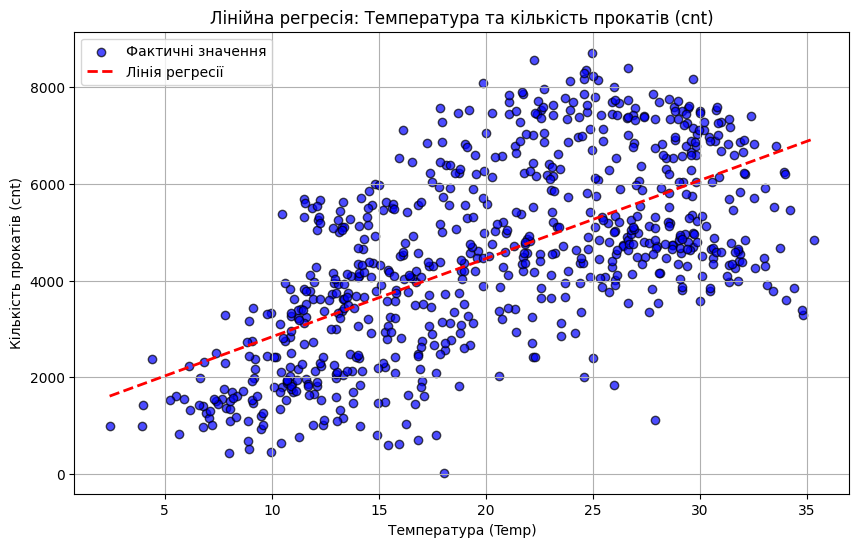


Результати моделі лінійної регресії (одна ознака - температура):

Коефіцієнти моделі: [161.96853655]

Перехоплення моделі: 1214.6421190294022

Коефіцієнт для ознаки 'temp': 161.96853654996673



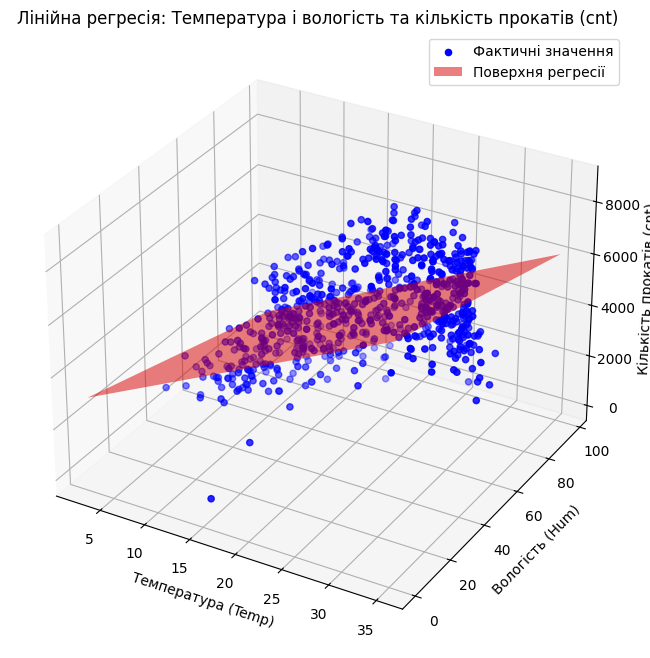


Результати моделі лінійної регресії (дві ознаки - температура і вологість):

Коефіцієнти моделі: [167.97496897 -24.92854127]

Перехоплення: 2657.895119831417

Коефіцієнт для ознаки 'temp': 167.97496896991052

Коефіцієнт для ознаки 'hum': -24.92854127207561


Результати моделі лінійної регресії (усі ознаки):

Коефіцієнти моделі: [ 5.70863796e+02  1.02196538e+03 -1.41301745e+02 -8.67593446e+01
  1.37225064e+02  5.63918818e+01 -3.30226462e+02  3.67483733e+02
  5.85549386e+02 -1.45614306e+02  1.24571384e+13 -1.24571384e+13]

Перехоплення моделі: 4504.354528214392

Коефіцієнт для ознаки 'season': 570.8637960129914

Коефіцієнт для ознаки 'yr': 1021.9653779400622

Коефіцієнт для ознаки 'mnth': -141.3017451148728

Коефіцієнт для ознаки 'holiday': -86.7593446245368

Коефіцієнт для ознаки 'weekday': 137.22506441350538

Коефіцієнт для ознаки 'workingday': 56.391881775973005

Коефіцієнт для ознаки 'weathersit': -330.2264620440312

Коефіцієнт для ознаки 'temp': 367.48373260182126

Коефіцієнт для о

In [ ]:
# Імпорт необхідних бібліотек
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler


# OДНА ОЗНАКА (лінійна регресія з температурою)

df_shuffled = shuffle(df, random_state=42)  # Перемішуємо дані
X = df_shuffled['temp'].values.reshape(-1, 1)  # Вибираємо лише ознаку 'temp' (температура)
y = df_shuffled["cnt"]  # Вибираємо цільову змінну 'cnt' (кількість прокатів)

model = LinearRegression()  # Створюємо модель лінійної регресії

# Тренуємо модель
model.fit(X, y)

# Робимо прогнози
y_pred = model.predict(X)

# Побудова графіка
plt.figure(figsize=(10, 6))

# Графік розсіювання для фактичних даних
plt.scatter(X, y, color='blue', edgecolor='k', alpha=0.7, label='Фактичні значення')

# Створюємо лінію регресії
temp_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)  # Створюємо діапазон температур
y_range_pred = model.predict(temp_range)  # Прогнозуємо значення для цього діапазону

# Малюємо лінію регресії
plt.plot(temp_range, y_range_pred, color='red', linestyle='--', lw=2, label='Лінія регресії')

# Заголовки та підписи
plt.title('Лінійна регресія: Температура та кількість прокатів (cnt)')
plt.xlabel('Температура (Temp)')
plt.ylabel('Кількість прокатів (cnt)')
plt.legend()

plt.grid(True)
plt.show()

# Виведення результатів моделі
print()
print("Результати моделі лінійної регресії (одна ознака - температура):")
print()

print(f"Коефіцієнти моделі: {model.coef_}")  # Коефіцієнт моделі
print()

print(f"Перехоплення моделі: {model.intercept_}")  # Перехоплення (вільний член)
print()

# Виведення пари (назва ознаки, вага)
feature_names = ['temp']
weights = model.coef_  # Вага ознак

# Створюємо пари (назва ознаки, вага) та виводимо їх
feature_weight_pairs = list(zip(feature_names, weights))
for feature, weight in feature_weight_pairs:
    print(f"Коефіцієнт для ознаки '{feature}': {weight}")
    print()



# ДВІ ОЗНАКИ (лінійна регресія з температурою і вологістю)

df_shuffled = shuffle(df, random_state=42)  # Перемішуємо дані
X = df_shuffled[['temp', 'hum']]  # Вибираємо дві ознаки: температура та вологість
y = df_shuffled["cnt"]  # Цільова змінна - кількість прокатів

model = LinearRegression()  # Створюємо модель лінійної регресії

# Тренуємо модель
model.fit(X, y)

# Робимо прогнози
y_pred = model.predict(X)

# Побудова 3D графіка для регресії
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Графік розсіювання для фактичних даних
ax.scatter(X['temp'], X['hum'], y, color='blue', label='Фактичні значення')

# Створюємо сітку для прогнозування значень
temp_range = np.linspace(X['temp'].min(), X['temp'].max(), 100)
atemp_range = np.linspace(X['hum'].min(), X['hum'].max(), 100)
temp_grid, atemp_grid = np.meshgrid(temp_range, atemp_range)
X_grid = pd.DataFrame(np.column_stack([temp_grid.ravel(), atemp_grid.ravel()]), columns=['temp', 'hum'])

# Прогнозуємо значення на сітці
y_grid_pred = model.predict(X_grid).reshape(temp_grid.shape)

# Малюємо поверхню регресії
ax.plot_surface(temp_grid, atemp_grid, y_grid_pred, color='red', alpha=0.5, rstride=100, cstride=100, label='Поверхня регресії')

# Підписи та заголовки
ax.set_title('Лінійна регресія: Температура і вологість та кількість прокатів (cnt)')
ax.set_xlabel('Температура (Temp)')
ax.set_ylabel('Вологість (Hum)')
ax.set_zlabel('Кількість прокатів (cnt)')

# Показуємо графік
plt.legend()
plt.show()

# Виведення коефіцієнтів і перехоплення моделі
print()
print(f"Результати моделі лінійної регресії (дві ознаки - температура і вологість):")
print()

print(f"Коефіцієнти моделі: {model.coef_}")  # Коефіцієнти для кожної ознаки
print()

print(f"Перехоплення: {model.intercept_}")  # Перехоплення
print()

# Виведення пари (назва ознаки, вага)
feature_names = ['temp', 'hum']
weights = model.coef_  # Ваги для кожної ознаки

# Створюємо пари (назва ознаки, вага) та виводимо їх
feature_weight_pairs = list(zip(feature_names, weights))
for feature, weight in feature_weight_pairs:
    print(f"Коефіцієнт для ознаки '{feature}': {weight}")
    print()



# УСІ ОЗНАКИ (лінійна регресія з усіма доступними ознаками)

df_shuffled = shuffle(df, random_state=42)  # Перемішуємо дані
X = df_shuffled[df_shuffled.columns[:-1]]  # Вибираємо всі колонки, крім останньої (цільова змінна)
y = df_shuffled["cnt"]  # Цільова змінна - кількість прокатів

X_scaled = scale(X)  # Масштабуємо ознаки для поліпшення точності моделі

model = LinearRegression()  # Створюємо модель лінійної регресії

# Тренуємо модель
model.fit(X_scaled, y)

# Робимо прогнози
y_pred = model.predict(X_scaled)

# Виведення результатів моделі
print()
print("Результати моделі лінійної регресії (усі ознаки):")
print()

print(f"Коефіцієнти моделі: {model.coef_}")  # Коефіцієнти моделі
print()

print(f"Перехоплення моделі: {model.intercept_}")  # Перехоплення
print()

# Виведення пари (назва ознаки, вага)
feature_names = df.columns  # Назви всіх ознак
weights = model.coef_  # Ваги для кожної ознаки

# Створюємо пари (назва ознаки, вага) та виводимо їх
feature_weight_pairs = list(zip(feature_names[:-1], weights))
for feature, weight in feature_weight_pairs:
    print(f"Коефіцієнт для ознаки '{feature}': {weight}")
    print()


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
import pandas as pd

# Всі ознаки

df_shuffled = shuffle(df, random_state=42)  # Перемішуємо дані
X = df_shuffled[df_shuffled.columns[:-1]]  # Вибираємо всі стовпці, крім останнього (цільова змінна)
y = df_shuffled["cnt"]  # Цільова змінна - кількість прокатів

X_scaled = scale(X)  # Масштабуємо ознаки для поліпшення точності моделі

# Лінійна регресія
model = LinearRegression()

# Навчаємо модель
model.fit(X_scaled, y)

# Робимо прогнози
y_pred = model.predict(X_scaled)

# Виведення результатів моделі лінійної регресії
print("\nРезультати моделі лінійної регресії:")
print()
print(f"Коефіцієнти моделі: {model.coef_}")
print()
print(f"Перехоплення моделі: {model.intercept_}")
print()

# Виведення пари (назва ознаки, вага)
feature_names = df.columns
weights = model.coef_  # Ваги для кожної ознаки
feature_weight_pairs = list(zip(feature_names[:-1], weights))

# Виведення пар "назва ознаки - вага"
for feature, weight in feature_weight_pairs:
    print(f"{feature}: {weight}")



# Lasso Регресія (L1 Регуляризація)
lasso_model = Lasso(alpha=0.1)  # Ви можете налаштувати параметр alpha для контролю сили регуляризації
lasso_model.fit(X_scaled, y)
y_pred_lasso = lasso_model.predict(X_scaled)

# Виведення результатів моделі Lasso регресії
print("\nРезультати моделі Lasso регресії:")
print()
print(f"Коефіцієнти моделі: {lasso_model.coef_}")
print()
print(f"Перехоплення моделі: {lasso_model.intercept_}")
print()
# Виведення пари (назва ознаки, вага)
feature_weight_pairs = list(zip(feature_names[:-1], lasso_model.coef_))

# Виведення пар "назва ознаки - вага"
for feature, weight in feature_weight_pairs:
    print(f"{feature}: {weight}")



Результати моделі лінійної регресії:

Коефіцієнти моделі: [ 5.70863796e+02  1.02196538e+03 -1.41301745e+02 -8.67593446e+01
  1.37225064e+02  5.63918818e+01 -3.30226462e+02  3.67483733e+02
  5.85549386e+02 -1.45614306e+02  1.24571384e+13 -1.24571384e+13]

Перехоплення моделі: 4504.354528214392

season: 570.8637960129914
yr: 1021.9653779400622
mnth: -141.3017451148728
holiday: -86.7593446245368
weekday: 137.22506441350538
workingday: 56.391881775973005
weathersit: -330.2264620440312
temp: 367.48373260182126
atemp: 585.5493861188597
hum: -145.61430569885857
windspeed(mph): 12457138390688.885
windspeed(ms): -12457138390887.346

Результати моделі Lasso регресії:

Коефіцієнти моделі: [ 5.65321657e+02  1.02025610e+03 -1.33895006e+02 -8.66672792e+01
  1.38219834e+02  5.58703568e+01 -3.32695555e+02  3.77368324e+02
  5.75672782e+02 -1.44871247e+02 -1.98105578e+02 -2.82848084e-08]

Перехоплення моделі: 4504.3488372093025

season: 565.3216570612018
yr: 1020.2561015161349
mnth: -133.89500587503778

Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [ ]:
# Регресія з регуляризацією L2 (Ridge)

ridge_model = Ridge(alpha=1.0)  # Ви можете налаштувати параметр alpha, щоб контролювати силу регуляризації
ridge_model.fit(X_scaled, y)
y_pred_ridge = ridge_model.predict(X_scaled)

print("\nРезультати моделі регресії Ridge:")
print()
print(f"Коефіцієнти моделі: {ridge_model.coef_}")
print()
print(f"Перехоплення моделі: {ridge_model.intercept_}")
print()

# Створення пар "назва ознаки - вага" для кожної ознаки
feature_weight_pairs = list(zip(feature_names[:-1], ridge_model.coef_))

# Виведення пар "назва ознаки - вага"
for feature, weight in feature_weight_pairs:
    print(f"{feature}: {weight}")
    print()



Результати моделі регресії Ridge:

Коефіцієнти моделі: [ 563.06457225 1018.94837879 -131.87332028  -86.746098    138.00511118
   55.90311038 -332.3497885   386.45788919  566.34704706 -145.0713273
  -99.25944108  -99.25944115]

Перехоплення моделі: 4504.3488372093025

season: 563.0645722520181

yr: 1018.9483787875305

mnth: -131.87332028247715

holiday: -86.74609799709232

weekday: 138.00511117871918

workingday: 55.90311037506467

weathersit: -332.34978849907367

temp: 386.45788919190807

atemp: 566.3470470600669

hum: -145.07132729867195

windspeed(mph): -99.25944108179067

windspeed(ms): -99.25944115434177



### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [ ]:
#alphas = np.arange(1, 500, 50)

#coefs_lasso = # Put your code here
#coefs_ridge = # Put your code here

#for alpha in alphas:
    # Put your code here

# Put your code here


alphas = np.arange(1, 500, 50)
print(alphas)

coefs_lasso = []  # Put your code here
coefs_ridge = []  # Put your code here

for alpha in alphas:
    # Put your code here
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_scaled, y)
    coefs_lasso.append(lasso_model.coef_)


    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_scaled, y)
    coefs_ridge.append(ridge_model.coef_)


array_of_coefs_lasso = np.array(coefs_lasso)
array_of_coefs_ridge = np.array(coefs_ridge)


display(array_of_coefs_lasso)
print()
display(array_of_coefs_ridge)




[  1  51 101 151 201 251 301 351 401 451]


array([[ 5.60241616e+02,  1.01946349e+03, -1.28730627e+02,
        -8.61527813e+01,  1.37347894e+02,  5.52123706e+01,
        -3.32369857e+02,  3.76363236e+02,  5.76530794e+02,
        -1.44129155e+02, -1.97139689e+02, -2.80514042e-08],
       [ 4.10969632e+02,  9.77019409e+02, -0.00000000e+00,
        -5.34489688e+01,  9.19434374e+01,  1.75372118e+01,
        -3.18125568e+02,  3.22829934e+02,  6.10031512e+02,
        -9.10689615e+01, -1.45066095e+02, -2.29892889e-08],
       [ 3.70077089e+02,  9.35945490e+02,  0.00000000e+00,
        -1.21619360e+01,  4.88886342e+01,  0.00000000e+00,
        -3.08805664e+02,  2.69417263e+02,  6.32502623e+02,
        -2.75042876e+01, -9.37749037e+01, -2.41657943e-08],
       [ 3.32835717e+02,  8.91870058e+02,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.79616688e+02,  2.11052030e+02,  6.62920880e+02,
        -0.00000000e+00, -5.01551472e+01, -2.62789872e-08],
       [ 2.98134448e+02,  8.45652857e+02,  0.0000000

array([[ 563.06457225, 1018.94837879, -131.87332028,  -86.746098  ,
         138.00511118,   55.90311038, -332.3497885 ,  386.45788919,
         566.34704706, -145.0713273 ,  -99.25944108,  -99.25944115],
       [ 461.1786324 ,  954.30774189,  -41.56545001,  -84.91347027,
         126.60366663,   54.2516911 , -313.27515141,  458.90147709,
         481.44350031, -151.29101033, -101.62731482, -101.62731483],
       [ 403.97653045,  898.08362212,    5.67424346,  -81.91106159,
         117.94141144,   52.72848389, -298.40898086,  455.28986839,
         467.43141748, -152.68605059, -102.10167084, -102.10167084],
       [ 366.60423851,  848.46346471,   34.02728278,  -78.77196479,
         110.68012006,   51.25719208, -286.12515935,  447.47982533,
         455.75402966, -151.48320603, -102.00537592, -102.00537593],
       [ 339.74528956,  804.25104797,   52.48987295,  -75.71740756,
         104.40346414,   49.84189502, -275.48609488,  438.50968939,
         444.7642744 , -148.94396978, -101.5

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

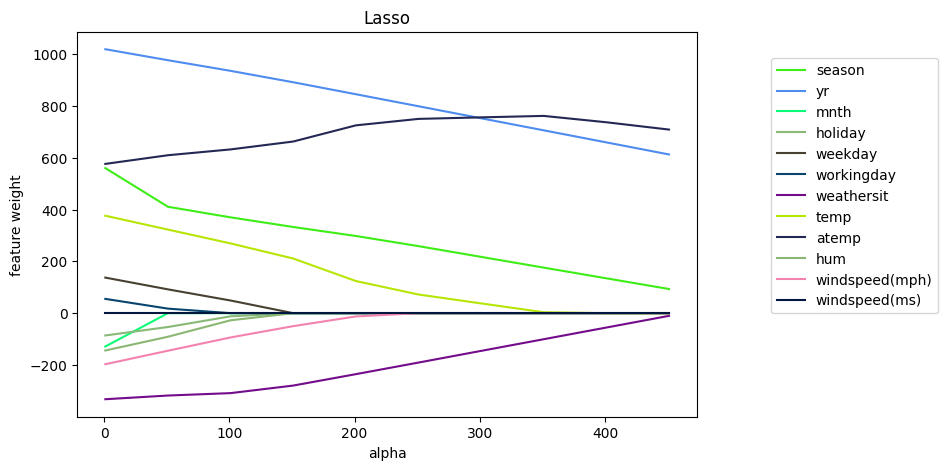

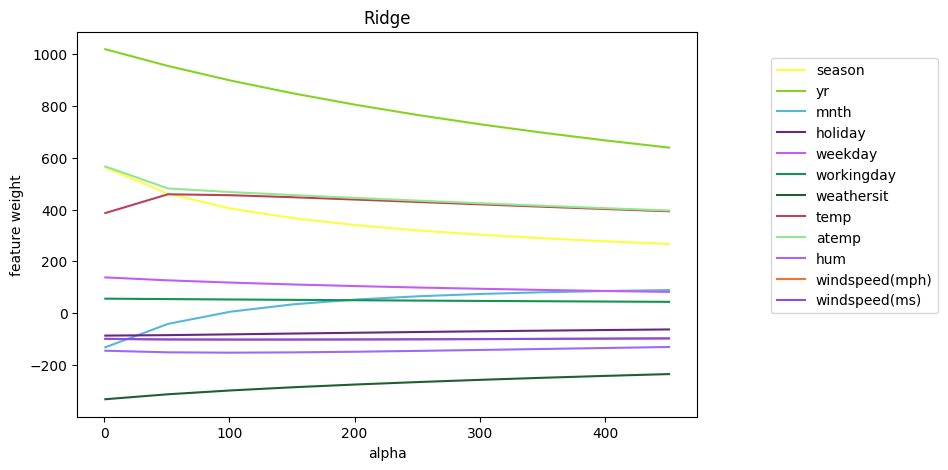

In [ ]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(array_of_coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(array_of_coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?


1. Відповідь:

Проаналізувавши графіки, можна сказати, що Lasso є більш агресивним до ваг більшості ознак.
Lasso є агресивнішим, бо він не просто зменшує ваги, а може повністю занулити коефіцієнти, виключаючи ознаки з моделі.

2. Відповідь:

У регресії Lasso (L1):


Коли alpha зростає, все більше коефіцієнтів стають точно рівними нулю.
Це означає, що модель автоматично вибирає найважливіші ознаки, ігноруючи менш значущі.
Lasso може використовуватися як метод вибору ознак, оскільки виключає ті, що мають незначний вплив
на результат.

Що це означає на практиці?
Малі значення alpha → більшість ознак залишаються в моделі, а коефіцієнти близькі до значень у лінійній
регресії.
Середні значення alpha → деякі коефіцієнти стають точно рівними нулю, тобто модель виключає менш важливі
ознаки.
Великі значення alpha → все більше коефіцієнтів дорівнює 0, і модель використовує лише кілька найважливіших
ознак.
Підсумок:
Lasso-регресія видаляє (зануляє) ті коефіцієнти, які мають найменший вплив на прогнози моделі.
Таким чином, вона працює як інструмент вибору ознак,
допомагаючи спростити модель та зменшити ризик перенавчання.

3. Відповідь:

Lasso (L1):


Так, можна стверджувати, що Lasso виключає одну з ознак `windspeed` при досить малих значеннях
alpha.  

 Lasso (L1) агресивно занулює коефіцієнти, коли `alpha > 0`.  
 Оскільки `windspeed(mph)` та `windspeed(ms)` є лінійно залежними ознаками (вони фактично є однаковими,
 просто в різних одиницях вимірювання), модель визначає їх як надлишкові.  
 Це означає, що Lasso, ймовірно, занулить одну з них уже при малих значеннях alpha,
 оскільки вони несуть однакову інформацію.  

Таким чином, при будь-якому `alpha > 0` Lasso, швидше за все, виключить одну з ознак windspeed.  

Ridge (L2):

Ні, Ridge не виключає жодної ознаки `windspeed`, незалежно від значення alpha.  

 Ridge (L2) зменшує всі коефіцієнти, але **не робить їх рівними нулю.  
 Навіть якщо `windspeed(mph)` та `windspeed(ms)` є лінійно залежними, Ridge просто зменшить їх коефіцієнти, але обидві ознаки залишаться в моделі.  
 Тому, на відміну від Lasso, Ridge не занулює ознаки навіть при дуже великих `alpha`.  


4. Відповідь:

Для відбору неінформативних ознак** краще використовувати регуляризатор Lasso (L1).

Чому Lasso?

Lasso (L1) регуляризатор має властивість **занулювати коефіцієнти для неінформативних ознак,
тобто він виключає ознаки з моделі**. Якщо ознака не дає суттєвого внеску в прогнозування,
її коефіцієнт буде наближатися до нуля, і модель фактично відкине цю ознаку.
Завдяки цьому Lasso є потужним інструментом для відбору ознак, оскільки він не
тільки зменшує значення коефіцієнтів, але й **змушує модель зберігати лише найважливіші ознаки.

Як працює Lasso для відбору ознак?

Lasso додає до функції втрат L1 норму (сума абсолютних значень коефіцієнтів),
що змушує модель шукати рішення з багатьма коефіцієнтами рівними нулю. Це означає, що менш
інформативні ознаки можуть бути просто видалені з моделі.
Для більш високих значень alpha, Lasso ще більше занулює коефіцієнти,
що дозволяє досягати жорсткішого відбору ознак.

Ridge (L2):

Ridge також зменшує коефіцієнти, але він не може занулити їх повністю.
У разі високої кореляції між ознаками, Ridge просто зменшує їхні ваги, але всі ознаки залишаються в моделі.
Таким чином, Ridge не призначений для відбору ознак, а скоріше для регулювання розмірів коефіцієнтів,
щоб зменшити вплив сильно корельованих ознак і уникнути перенавчання.

Для відбору неінформативних ознак найкращим вибором буде Lasso, оскільки він
занулює коефіцієнти незначущих ознак, тим самим виконуючи відбір ознак.




### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [ ]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

Найкраще значення alpha: 6
Best alpha selected by cross-validation: 6
Lasso coefficients: [ 5.32018983e+02  1.01506022e+03 -1.00039526e+02 -8.32939599e+01
  1.32504465e+02  5.15570856e+01 -3.30559857e+02  3.70679855e+02
  5.81396931e+02 -1.40007406e+02 -1.91771408e+02 -2.68547023e-08]
Intercept: 4504.3488372093025

season: 532.0189828413535
yr: 1015.0602226430595
mnth: -100.03952614356629
holiday: -83.29395987529904
weekday: 132.50446549095795
workingday: 51.557085614073735
weathersit: -330.5598567399817
temp: 370.67985503003405
atemp: 581.396931065498
hum: -140.00740550068844
windspeed(mph): -191.77140847135036
windspeed(ms): -2.6854702314758792e-08


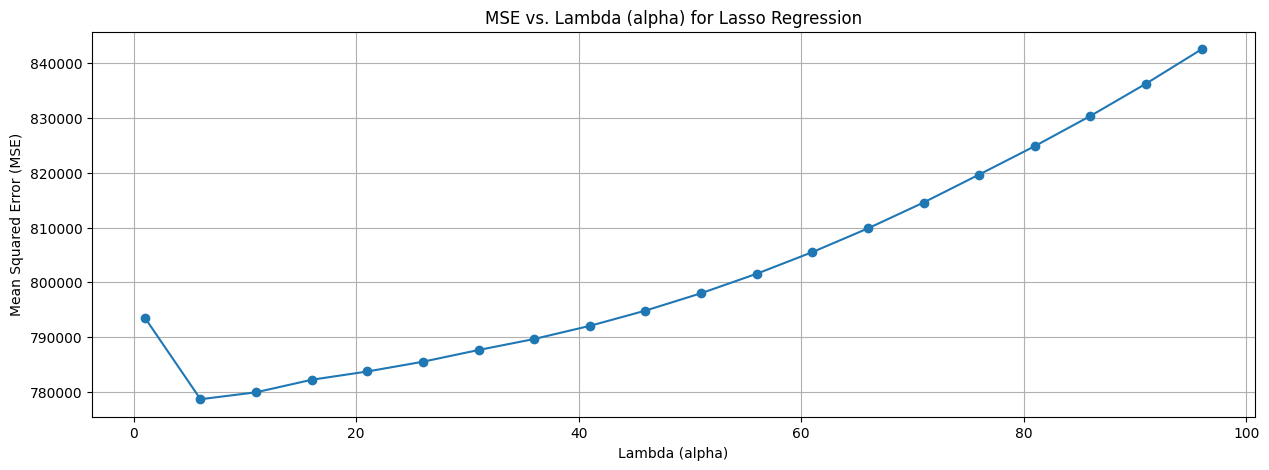

In [ ]:
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import numpy as np

# Масив значень alpha для перевірки
alphas = np.arange(1, 100, 5)

# Створення моделі LassoCV з крос-валідацією
regressor = LassoCV(alphas=alphas, cv=2, random_state=42)

# Навчання моделі
regressor.fit(X_scaled, y)

# Виведення найкращого alpha
print("Найкраще значення alpha:", regressor.alpha_)

# Обчислення середнього MSE
mse_mean = regressor.mse_path_.mean(axis=1)

# **Оновлено**: Використовуємо `regressor.alphas_`, а не `alphas`
data = list(zip(regressor.alphas_, mse_mean))
from sklearn.linear_model import LassoCV
import numpy as np

#alphas = np.arange(0.01, 10000, 2)
alphas = np.arange(1, 100, 5)


# Create the Lasso regression model with cross-validation
#regressor = LassoCV(alphas=alphas, cv=3, random_state=42)
regressor = LassoCV(alphas=alphas, cv=2, random_state=42)

# Fit the model to the scaled data (X_scaled, y)
regressor.fit(X_scaled, y)

# Print the best alpha value selected by cross-validation
print("Best alpha selected by cross-validation:", regressor.alpha_)

# Print the coefficients for each feature
print("Lasso coefficients:", regressor.coef_)

# Print the intercept
print("Intercept:", regressor.intercept_)
print()

# Make predictions using the fitted model
y_pred = regressor.predict(X_scaled)


rounded_coefs = np.round(regressor.coef_, 9)

feature_weight_pairs = list(zip(feature_names[:-1], regressor.coef_))

# Wyświetlanie par
for feature, weight in feature_weight_pairs:
    print(f"{feature}: {weight}")


# Plot mean squared error vs. lambda (alpha)
# plt.figure(figsize=(8, 6))
# plt.plot(regressor.alphas_, regressor.mse_path_.mean(axis=1), marker='o', linestyle='--', color='b')
# plt.axvline(regressor.alpha_, color='r', linestyle='--', label=f'Best alpha: {regressor.alpha_:.2f}')
# plt.xlabel('Lambda (alpha)')
# plt.ylabel('Mean Squared Error (MSE)')
# plt.title('MSE vs. Lambda (alpha) for Lasso Regression')
# plt.legend()
# plt.grid()
# plt.show()



# Prepare data for plotting
data = list(zip(regressor.alphas_, regressor.mse_path_.mean(axis=1)))
create_plot(data, 'MSE vs. Lambda (alpha) for Lasso Regression', 'Lambda (alpha)', 'Mean Squared Error (MSE)')




# Викликаємо функцію для побудови графіка
#create_plot(data, "Середній MSE vs Alpha", "Alpha", "Mean MSE")


Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Найкраще значення alpha: 6
MSE для кожного alpha:
 [[758642.13582104 844571.37518314 797422.81743706]
 [733725.73787369 804430.89878094 806483.67182876]
 [746611.46258326 799436.50687448 809131.01464407]]

   Partycja  Alpha        Min MSE
0         1      6  733725.737874
1         2      1  799436.506874
2         3     41  797422.817437



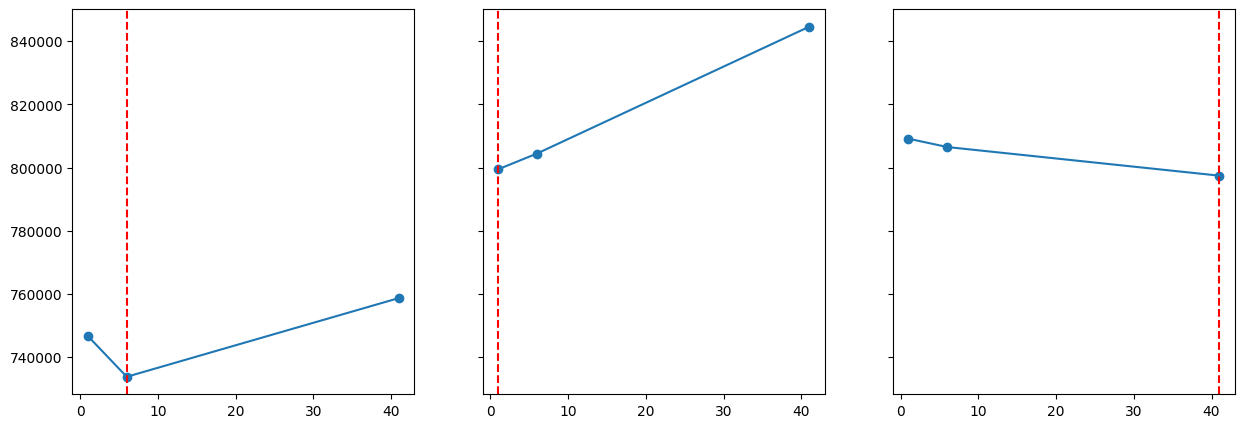

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV

# Визначаємо три конкретні значення alpha
alphas = np.array([41, 6, 1])

# Створюємо LassoCV з крос-валідацією
regressor = LassoCV(alphas=alphas, cv=3, random_state=42)

# Навчаємо модель
regressor.fit(X_scaled, y)

# Виводимо вибране значення alpha
print("Найкраще значення alpha:", regressor.alpha_)

# Отримуємо шлях MSE для кожної партіції валідації
mse_path = regressor.mse_path_

# Вивід значень MSE для кожного alpha
print("MSE для кожного alpha:\n", mse_path)
print()

# Знаходимо індекс мінімального MSE у кожній партіції
min_indices = np.argmin(mse_path, axis=0)

# Вибираємо відповідні alpha і MSE
best_alphas = alphas[min_indices]
min_mse_values = mse_path[min_indices, range(mse_path.shape[1])]

# Формуємо таблицю результатів
results = pd.DataFrame({
    'Partycja': np.arange(1, mse_path.shape[1] + 1),
    'Alpha': best_alphas,
    'Min MSE': min_mse_values
})

print(results)
print()

# Будуємо графіки MSE для кожної партіції
fig, axes = plt.subplots(1, mse_path.shape[1], figsize=(15, 5), sharey=True)

for i in range(mse_path.shape[1]):
    axes[i].plot(alphas, mse_path[:, i], marker='o', linestyle='-')
    axes[i].axvline(best_alphas[i], color='r', linestyle='--', label=f'Best alpha: {best_alphas[i]}')
    axes[i].set


Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей cnt від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність cnt від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?


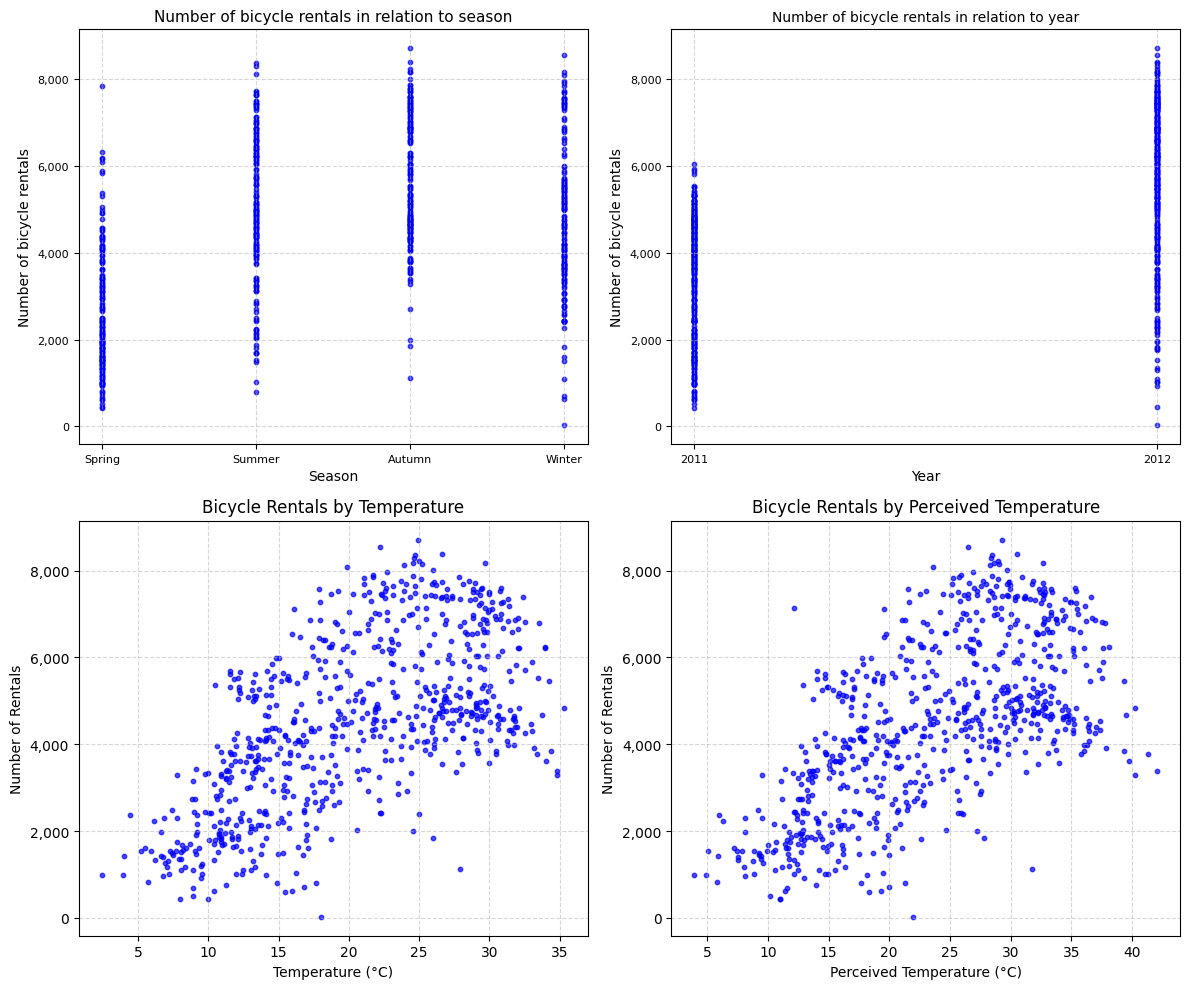

In [ ]:
# a  = yr, season, atemp, temp

# season: 532.018982841 #третя ознака з найбільшим позитивним коефіцієнтом
# yr: 1015.060222643    #перша ознака з найбільшим позитивним коефіцієнтом
# mnth: -100.039526144
# holiday: -83.293959875
# weekday: 132.504465491
# workingday: 51.557085614
# weathersit: -330.55985674
# temp: 370.67985503    #четверта ознака з найбільшим позитивним коефіцієнтом
# atemp: 581.396931065  #друга ознака з найбільшим позитивним коефіцієнтом
# hum: -140.007405501
# windspeed(mph): -191.771408471
# windspeed(ms): -2.7e-08


from matplotlib.ticker import FuncFormatter

# Put you code here
df['season_label'] = df['season'].map({1: 'Spring', 2: 'Summer', 3: 'Autumn', 4: 'Winter'})
df['year_label'] = df['yr'].map({0: '2011', 1: '2012'})
#df['holiday_label'] = df['holiday'].map({0: 'Regular day', 1: 'Holiday'})
#df['working_day_label'] = df['workingday'].map({0: 'Not working day', 1: 'Working day'})
#df['weathersit_label'] = df['weathersit'].map({1: 'Clear', 2: 'Partially Clear', 3: 'Rain', 4: 'Rain / Fog'})
df['temp_int'] = df['temp'].astype(int)
df['atemp_int'] = df['atemp'].astype(int)
#df['humidity_int'] = df['hum'].astype(int)
#df['wind_speed_mph_rnd'] = df['windspeed(mph)'].round()
#df['wind_speed_ms_rnd'] = df['windspeed(ms)'].round()

def format_large_numbers(x, pos):
    return f'{int(x):,}'

fig, axes = plt.subplots(2, 2, figsize=(12, 10)) # 1 row, 2 columns
#seasonly_sum = df.groupby('season_label')['cnt'].sum()
#print(seasonly_sum)
axes[0][0].scatter(df['season_label'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[0][0].set_title("Number of bicycle rentals in relation to season", fontsize=11)
axes[0][0].set_xlabel("Season", fontsize=10)
axes[0][0].tick_params(axis='x', labelsize=8)
axes[0][0].set_ylabel("Number of bicycle rentals", fontsize=10)
axes[0][0].tick_params(axis='y', labelsize=8)
axes[0][0].grid(True, linestyle='--', alpha=0.5)
axes[0][0].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))


yearly_sum = df.groupby('year_label')['cnt'].sum()
#print(yearly_sum)
#axes[0][1].bar(yearly_sum.index, yearly_sum.values, edgecolor='blue', width=0.5 )# linestyle='-', color='orange')
axes[0][1].scatter(df['year_label'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[0][1].set_title("Number of bicycle rentals in relation to year", fontsize=10)
axes[0][1].set_xlabel("Year", fontsize=10)
axes[0][1].tick_params(axis='x', labelsize=8)
axes[0][1].set_ylabel("Number of bicycle rentals", fontsize=10)
axes[0][1].tick_params(axis='y', labelsize=8)
axes[0][1].grid(True, linestyle='--', alpha=0.5)
axes[0][1].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))



# 🚲 **3rd Plot: Rentals vs Temperature**
axes[1, 0].scatter(df['temp'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[1, 0].set_title("Bicycle Rentals by Temperature")
axes[1, 0].set_xlabel("Temperature (°C)")
axes[1, 0].set_ylabel("Number of Rentals")
axes[1, 0].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
axes[1, 0].grid(True, linestyle='--', alpha=0.5)

# 🚲 **4th Plot: Rentals vs Perceived Temperature**
axes[1, 1].scatter(df['atemp'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[1, 1].set_title("Bicycle Rentals by Perceived Temperature")
axes[1, 1].set_xlabel("Perceived Temperature (°C)")
axes[1, 1].set_ylabel("Number of Rentals")
axes[1, 1].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
axes[1, 1].grid(True, linestyle='--', alpha=0.5)





plt.tight_layout()
plt.show()

Запитання 1

Відповідь:

Аналіз графіків залежності cnt від цих ознак:
yr (Рік)
Графік показує чітку зростаючу тенденцію: у 2012 році кількість оренд значно вища, ніж у 2011.
Це логічно, оскільки популярність сервісу прокату велосипедів зростає з часом.
atemp (Відчутна температура)


Залежність теж є зростаючою: при комфортній температурі люди частіше беруть велосипеди.
Дуже холодна або дуже спекотна погода може зменшувати попит, але в загальному тренд позитивний.


season (Сезон)
Відчутний вплив сезону: найбільше оренд влітку та восени, менше взимку.
Логічно, що в теплі сезони більше людей користуються велосипедами.


temp (Температура)
Чітка позитивна кореляція: що вища температура, то більше оренд, але до певної межі.
У дуже жарку погоду попит може спадати, але в середньому тепла погода сприяє збільшенню оренд.



Чи логічно стверджувати, що збільшення цих ознак веде до зростання кількості оренд?
Так, це логічно:

Чим новіший рік (yr), тим більше людей дізнається про сервіс, зростає популярність.


Вища температура (temp) та комфортна температура (atemp) сприяють велопоїздкам.


Сезон впливає на оренди: влітку та восени велосипедами користуються частіше, ніж узимку.


Отже, можна стверджувати, що чим більше значення цих ознак, тим більше людей хочуть взяти велосипеди



#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

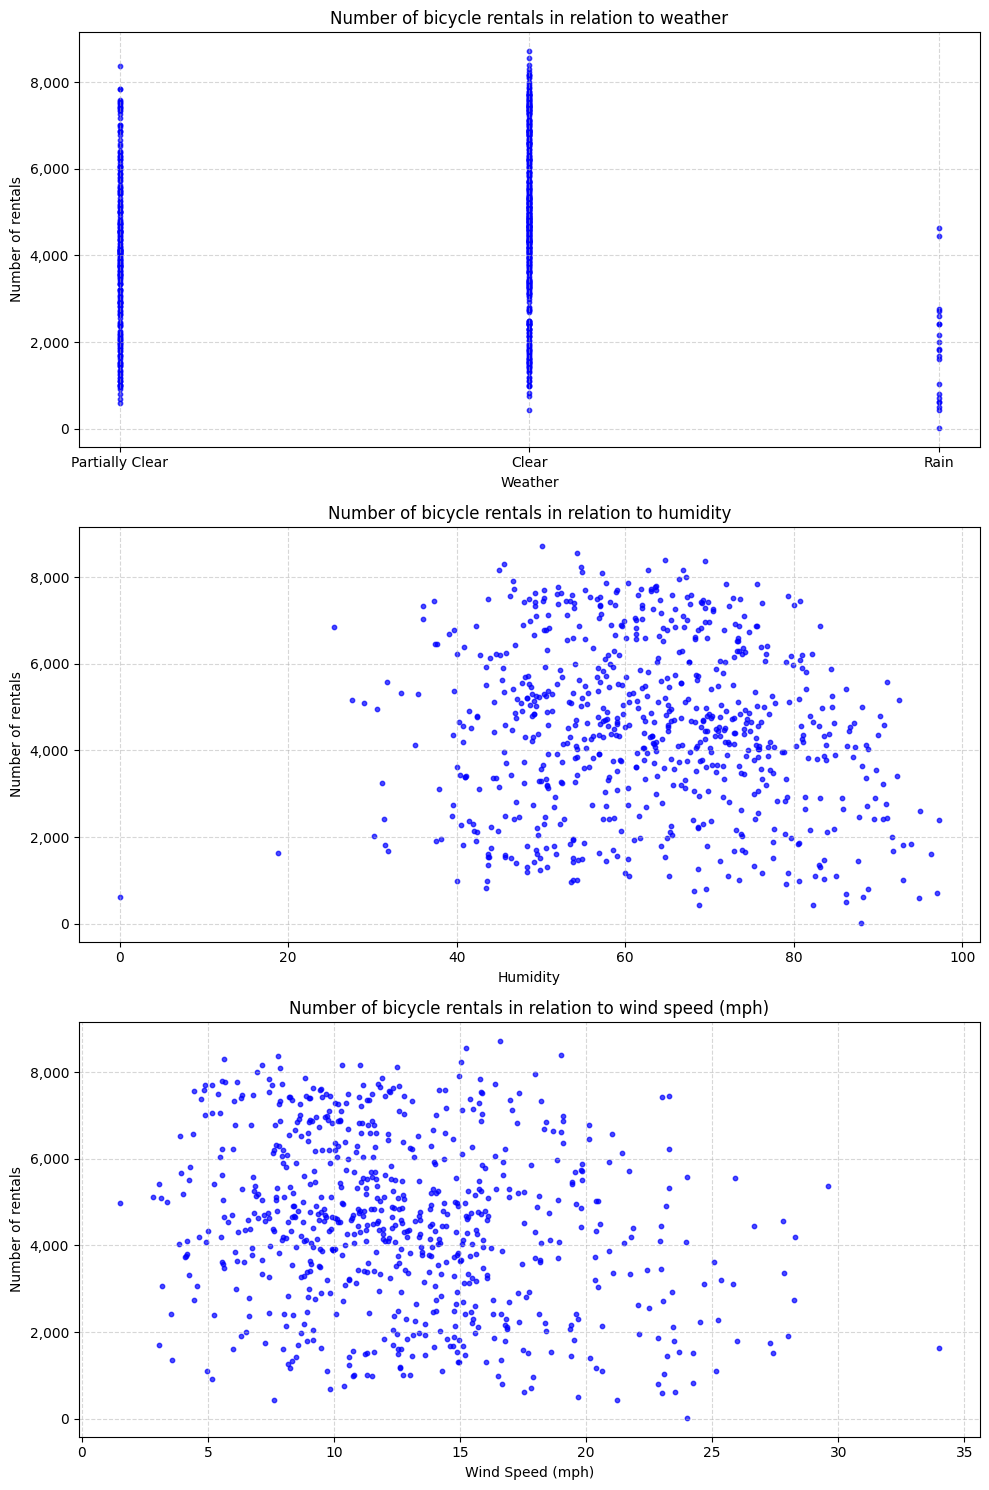

In [ ]:

# a  = weathersit, windspeed, humidity

# season: 532.018982841
# yr: 1015.060222643
# mnth: -100.039526144
# holiday: -83.293959875
# weekday: 132.504465491
# workingday: 51.557085614
# weathersit: -330.55985674     # перша ознака з найбільшим негативним коефіцієнтом
# temp: 370.67985503
# atemp: 581.396931065
# hum: -140.007405501         # третя ознака з найбільшим негативним коефіцієнтом
# windspeed(mph): -191.771408471    # друга ознака з найбільшим негативним коефіцієнтом
# windspeed(ms): -2.7e-08


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Map categorical labels
df['weathersit_label'] = df['weathersit'].map({1: 'Clear', 2: 'Partially Clear', 3: 'Rain', 4: 'Rain / Fog'})

# Define function to format large numbers
def format_large_numbers(x, pos):
    return f'{int(x):,}'

# Create subplots: 3 rows, 1 column
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Weather situation
axes[0].scatter(df['weathersit_label'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[0].set_title("Number of bicycle rentals in relation to weather", fontsize=12)
axes[0].set_xlabel("Weather", fontsize=10)
axes[0].set_ylabel("Number of rentals", fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))

# Humidity
axes[1].scatter(df['hum'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[1].set_title("Number of bicycle rentals in relation to humidity", fontsize=12)
axes[1].set_xlabel("Humidity", fontsize=10)
axes[1].set_ylabel("Number of rentals", fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))

# Wind speed
axes[2].scatter(df['windspeed(mph)'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[2].set_title("Number of bicycle rentals in relation to wind speed (mph)", fontsize=12)
axes[2].set_xlabel("Wind Speed (mph)", fontsize=10)
axes[2].set_ylabel("Number of rentals", fontsize=10)
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))

# Adjust layout
plt.tight_layout()
plt.show()


### **Вибрані ознаки з найбільшими за модулем негативними коефіцієнтами:**
1. **Weathersit** (-330.56) → перша ознака з найбільшим негативним коефіцієнтом  
2. **Windspeed (mph)** (-191.77) → друга ознака з найбільшим негативним коефіцієнтом  
3. **Humidity** (-140.01) → третя ознака з найбільшим негативним коефіцієнтом  

---

### **Аналіз візуалізацій**
1. **Weathersit (Погодні умови)**  
   - З графіка видно, що за гірших погодних умов (дощ, туман) кількість оренд велосипедів **значно зменшується**.  
   - Це логічно: у дощ або туман люди рідше користуються велосипедами.  
   - **Очевидна зменшувальна залежність**.

2. **Windspeed (Швидкість вітру)**  
   - Графік показує, що зі збільшенням швидкості вітру оренди велосипедів **зменшуються**.  
   - Це також логічно: сильний вітер створює незручності при їзді.  
   - **Помітна негативна лінійна залежність**.

3. **Humidity (Вологість)**  
   - Спостерігається зменшення кількості оренд при **високій вологості**.  
   - Логічно: висока вологість може створювати дискомфорт, особливо в спеку.  
   - **Слабка, але помітна негативна залежність**.

---

### **Висновки**
✅ Так, на всіх трьох графіках спостерігається **зменшувальна лінійна залежність** між ознаками та кількістю оренд.  
✅ Логічно припустити, що за поганих погодних умов, сильного вітру та високої вологості люди менше користуються велосипедами.  
✅ **Найсильніший вплив має погода (weathersit), а потім вітер і вологість**.  



#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

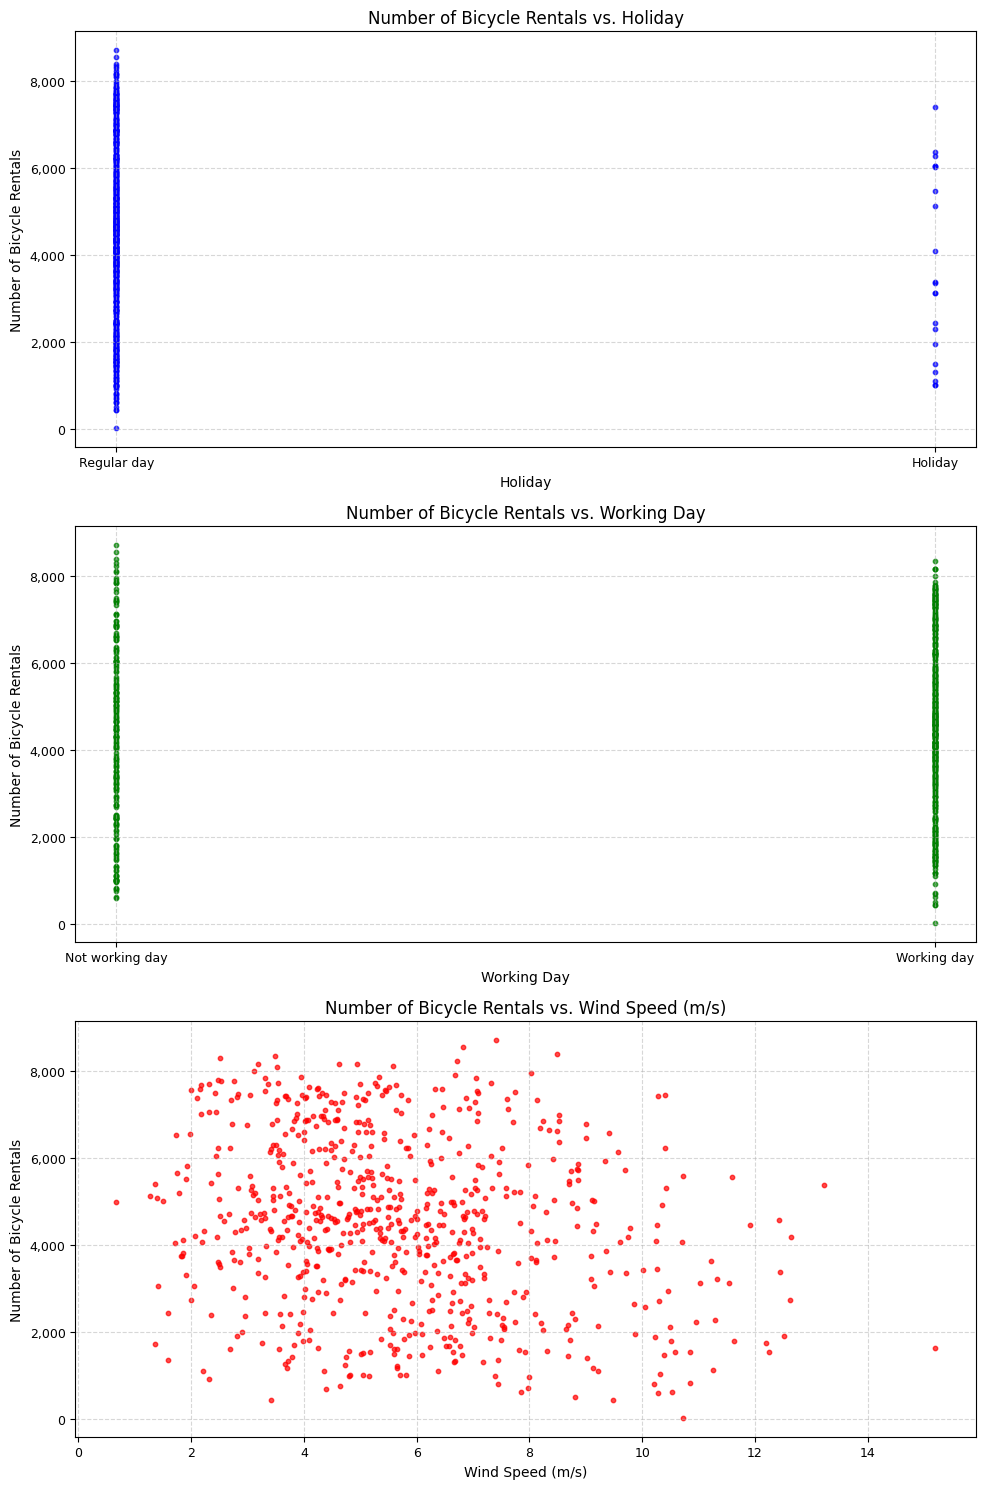

In [ ]:
# a =
# season: 532.0189828413535
# yr: 1015.0602226430595
# mnth: -100.03952614356629
# holiday: -83.29395987529904
# weekday: 132.50446549095795
# workingday: 51.557085614073735
# weathersit: -330.5598567399817
# temp: 370.67985503003405
# atemp: 581.396931065498
# hum: -140.00740550068844
# windspeed(mph): -191.77140847135036
# windspeed(ms): -2.6854702314758792e-08

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Function to format large numbers
def format_large_numbers(x, pos):
    return f'{int(x):,}'

# Create a figure with 3 subplots (one column)
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# 🔹 Graph 1: Bicycle Rentals vs. Holiday
axes[0].scatter(df['holiday_label'], df['cnt'], color='blue', s=10, alpha=0.7)
axes[0].set_title("Number of Bicycle Rentals vs. Holiday", fontsize=12)
axes[0].set_xlabel("Holiday", fontsize=10)
axes[0].tick_params(axis='x', labelsize=9)
axes[0].set_ylabel("Number of Bicycle Rentals", fontsize=10)
axes[0].tick_params(axis='y', labelsize=9)
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))

# 🔹 Graph 2: Bicycle Rentals vs. Working Day
axes[1].scatter(df['working_day_label'], df['cnt'], color='green', s=10, alpha=0.7)
axes[1].set_title("Number of Bicycle Rentals vs. Working Day", fontsize=12)
axes[1].set_xlabel("Working Day", fontsize=10)
axes[1].tick_params(axis='x', labelsize=9)
axes[1].set_ylabel("Number of Bicycle Rentals", fontsize=10)
axes[1].tick_params(axis='y', labelsize=9)
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))

# 🔹 Graph 3: Bicycle Rentals vs. Wind Speed (m/s)
axes[2].scatter(df['windspeed(ms)'], df['cnt'], color='red', s=10, alpha=0.7)
axes[2].set_title("Number of Bicycle Rentals vs. Wind Speed (m/s)", fontsize=12)
axes[2].set_xlabel("Wind Speed (m/s)", fontsize=10)
axes[2].tick_params(axis='x', labelsize=9)
axes[2].set_ylabel("Number of Bicycle Rentals", fontsize=10)
axes[2].tick_params(axis='y', labelsize=9)
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))

plt.tight_layout()
plt.show()



Ознаки, близькі до нуля, — це ті, що мають найменші абсолютні значення. Дивлячись на наведені коефіцієнти, найближчими до нуля є:

Windspeed (ms) → -2.69e-08 (майже нульове значення)


Holiday → -83.29


Workingday → 51.56

Аналіз:
✅ Windspeed (ms) має надзвичайно малий коефіцієнт (-2.69e-08), фактично наближений до нуля. Це означає, що швидкість вітру в м/с майже не впливає на кількість оренд.

✅ Holiday та Workingday також мають досить малі абсолютні значення, тобто їхній вплив на кількість оренд слабкий у порівнянні з іншими ознаками.


Модель могла виключити ці ознаки через кілька причин:  

### **1️⃣ Їхній вплив майже нульовий**  
- **Windspeed (ms)** має коефіцієнт **-2.69e-08**, що практично дорівнює нулю.  
- Це означає, що **зміни швидкості вітру в м/с майже не впливають** на попит на велосипеди.  
- Можливо, люди не сприймають **вітер** як важливий фактор при прийнятті рішення про оренду.  

---

### **2️⃣ Ознаки можуть бути корельованими з іншими**  
- **Holiday (-83.29)** та **Workingday (51.56)** мають **невеликі** коефіцієнти, що вказує на слабкий вплив.  
- Водночас, **weekday (132.50)** вже є в моделі, і він може **частково пояснювати вплив свят і робочих днів**.  
- Якщо одна ознака сильно **корелює з іншою**, модель може відкинути менш значущу.  

---

### **3️⃣ Графіки не показують чіткої залежності**  
- Якщо подивитися на **графіки попиту від holiday, workingday, windspeed**, то, швидше за все, **немає чіткої тенденції**.  
- Наприклад, якщо на графіку розсіювання **велосипедні оренди виглядають хаотично** без явної тенденції вгору або вниз, це означає, що **залежність слабка**.  
- У такому випадку модель **автоматично знижує вагу цих змінних або взагалі їх виключає**.  

---

### **Висновок: Чи правда, що вони ніяк не впливають?**  
🔹 **Вони можуть мати невеликий вплив**, але модель вважає, що **вони не критичні** для прогнозування.  
🔹 **Windspeed (ms)** майже не впливає на оренди.  
🔹 **Holiday і Workingday можуть мати вплив**, але, можливо, він **уже врахований іншими ознаками** (наприклад, weekday).  
🔹 **Фактичний вплив можна перевірити через статистичні тести або порівняння різних моделей.**  

Тобто, **вони не є абсолютно "незначущими", але їхній вплив слабкий або дублюється іншими змінними**.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.